# BATADAL - ARMA Task

The BATtle of the Attack Detection ALgorithms (BATADAL) data is the hourly historical supervisory control and data acquisition (SCADA) operations of the C-Town water distribution system ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/(ASCE)WR.1943-5452.0000969)).

The purpose of this *ARMA (autoregressive moving average model)* task is to learn an ARMA model for at least 5 individual sensors (pick them in a sensible way!). Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using *Akaike's Information Criterion (AIC)* or another model selection method. Note that there exists a wide range of ARMA variants; we only have to use the basic model. Decide how to set the detection threshold sensibly, study some of the detected anomalies, and answer the following questions:

- What kind of anomalies can you detect using ARMA models? 
- Which sensors can be modeled effectively using ARMA?

## Description of the datasets

Three BATADAL datasets ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/(ASCE)WR.1943-5452.0000969)) are available:

1. *Training dataset 1:* A one-year long simulation data, does not contain any attacks, i.e., all te data pertains to C-Town normal operations.
2. *Training dataset 2:* Partially labelled data of around 6 months long and contains several attacks, some of which are approximately labelled.
3. *Test dataset:* A 3-months long dataset which contains several attacks but no labels. Supposed to be used to compare the performance of the algorithms.

*In this ARMA task we use only the all three datasets to demonstrate our work.*

In [54]:
%matplotlib inline
import pandas as pd
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, ARMA
from statsmodels.tools.eval_measures import mse

## Demonstrate the task with variable L_T3
From the familiarization task we knew that tank T3-related parameters have a relatively clear cyclic behaviour. We first would like to demonstrate the ARMA model with an “easy-to-model” variable. The water level of tank T3, L_T3, was chosen for this demonstration. *In this demontration, we use only the first training dataset.*

### Autocorrelation plots
We therefore first make autocorrelation plots for the variable L_T3 to get familiar with the ARMA process.

In [2]:
# Load dataset
dftrain1 = pd.read_csv('./data/BATADAL_dataset03.csv')

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))

Text(0.5, 0, 'Time (hr)')

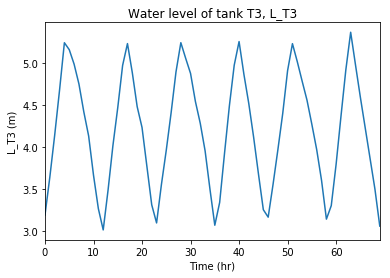

In [68]:
# split data into train and test datasets
def split_train_test(df, n = 24): # n = test size
    train = df[:-n]
    test = df[-n:]
    return train, test

# split the variable in interest (L_T3, tank T3)
train, test = split_train_test(dftrain1.L_T3, n = 24*3)

# plot (a subset of) the training data
train[0:70].plot()
plt.title('Water level of tank T3, L_T3')
plt.ylabel('L_T3 (m)')
plt.xlabel('Time (hr)')

We'd like to find an estimate of appropriate values of p and q in the ARMA(p,q) model. This is done by plotting ([P. Bloomfield, 2011](https://www.stat.ncsu.edu/people/bloomfield/courses/st730/slides/SnS-03-3.pdf)): 
- Partial autocorrelation functions (PACF) for an estimate of *p*, where AR(*p*) is characterized by
  - non-zero at lag *p* and 
  - zeros for lags larger than *p*
- Autocorrelation functions (ACF) for an estimate of q, where MA(*q*) is characterized by
  - non-zero at lag *q* and
  - zeros for lags larger than *q*

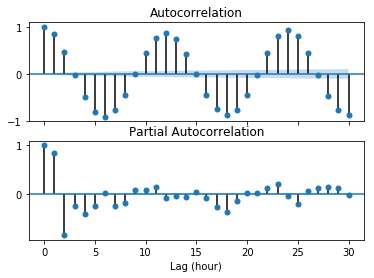

In [4]:
# plot autocorrelation plot and partial autocorrelation plot
def acf_plots(df, lag = 30):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (6, 4))
    
    fig = plot_acf(df, lags = lag, ax = ax1)
    fig = plot_pacf(df, lags = lag, ax = ax2)
    
    ax2.set_xlabel('Lag (hour)')

# plot for training data
acf_plots(train, lag = 30)

From the above PCF plot, we can see that the first spike is located at somewhere lag *p* = 6 or 9. 

Yet it is still difficult to identify the order of lag *q* from above ACF plot. We then make a grid search for finding the order (p, q).

### Akaike Information Critera (AIC)
We can check the order by calculating the Akaike Information Critera (AIC) values for the ARMA models. The AIC is a statistical measure which basically quantifies the 1) the goodness of fit and 2) the simplicity/parsimony of the model into a single statistic ([CoolStatsBlog, 2013](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)). The one with the lower AIC is generally “better”, but we're also interested in the “convergence” of the AIC values, i.e., the “good enough” result with the least computation resources.

In [70]:
# perform aic calculations given orders (p, q) and plot the aic grid
def aic_heatmap(df, ps = range(1, 3), qs = range(1, 3), title = 'AIC Grid'):
    aic = [[p, q, ARMA(df, order=(p, q)).fit().aic]
           for p in ps for q in qs if ((p!=0)|(q!=0))]
    aic = pd.DataFrame(aic, columns = ['p', 'q', 'aic'])
    
    # plot heatmap showing aic values vs (p, q) parameters
    sns.heatmap(aic.pivot('p', 'q', 'aic'), 
                annot = True, fmt='0.1f', linewidths=1)
    plt.title(title)

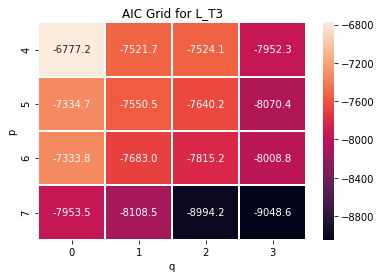

In [73]:
aic_heatmap(train, ps = range(4, 7+1), qs = range(0, 3+1), 
            title = 'AIC Grid for L_T3')

### Predicting the next value
We can see from the AIC grid graph that higher orders of p and q return a lower AIC score, and that in this grid search, the parameter set of (p, q) = (2, 1) gives a sufficiently good result. After the order of (2, 1), an increase in either p or q gives relatively small improvement in the AIC score. We therefore proceed with an ARMA model with an order of (2, 1).

In [12]:
# train model to predict the next value per time tick
def arma_train_predict(train, test, p, q):
    # set history (=training data) and dummy list for prediction
    history = [x for x in train]
    predictions = []
    
    # train and predict the next time tick of L_T3
    for t in range(len(test)):
        model = ARMA(history, order = (p, q)).fit()
        output = model.predict(start = len(history), end = len(history))
        predictions.append(float(output))
        history.append(test.values[t])
    
    # calculate mean square error
    error = mse(test.values, np.array(predictions))
    
    return predictions, error

In [74]:
# perform arma modeling and predicting
predictions, error = arma_train_predict(train, test, p=7, q=2)

print('ARMA resulting mean square error: %0.3f' % error)

ARMA resulting mean square error: 0.019


In [14]:
# plot the real vs prediction data
def real_vs_predict(test, predictions, title = 'Variable in interest',
                    ylabel = 'Unit', xlabel = 'Time (hr)'):
    comparison = pd.DataFrame({'original' : test,
                               'predict' : predictions})
    comparison.plot(style = ['b--','r--'])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

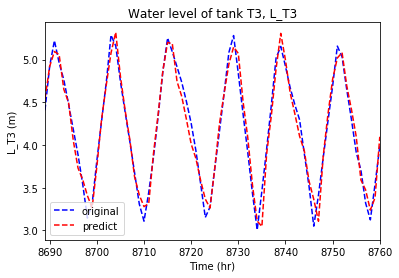

In [75]:
real_vs_predict(test, predictions, 
                title = 'Water level of tank T3, L_T3', 
                ylabel = 'L_T3 (m)')

## Other signals

### Water level of tank T1, *L_T1*

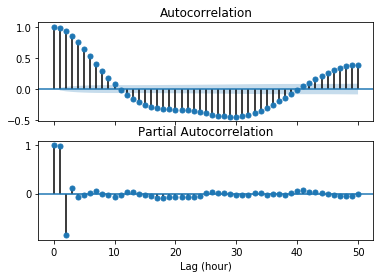

In [41]:
train, test = split_train_test(dftrain1.L_T1, n = 24*3)
acf_plots(train, lag = 50)

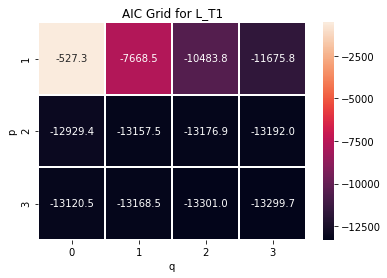

In [25]:
aic_heatmap(train, ps = range(1, 3+1), qs = range(0, 3+1), 
            title = 'AIC Grid for L_T1')

In [26]:
predictions, error = arma_train_predict(train, test, p=2, q=0)

print('ARMA resulting mean square error: %0.3f' % error)

ARMA resulting mean square error: 0.013


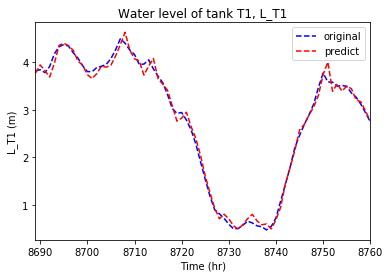

In [27]:
real_vs_predict(test, predictions, 
                title = 'Water level of tank T1, L_T1', 
                ylabel = 'L_T1 (m)')

### Water level of tank T2, *L_T2*

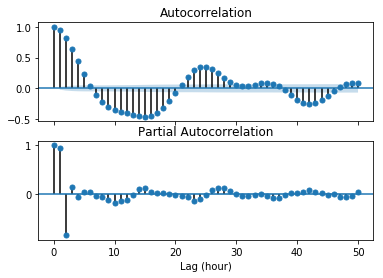

In [45]:
train, test = split_train_test(dftrain1.L_T2, n = 24*3)
acf_plots(train, lag = 50)

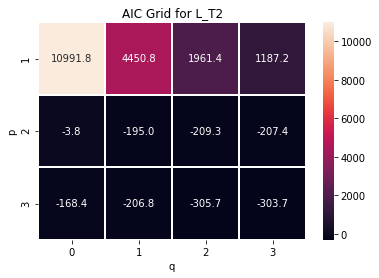

In [30]:
aic_heatmap(train, ps = range(1, 3+1), qs = range(0, 3+1), 
            title = 'AIC Grid for L_T2')

In [31]:
predictions, error = arma_train_predict(train, test, p=2, q=0)

print('ARMA resulting mean square error: %0.3f' % error)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARMA resulting mean square error: 0.049


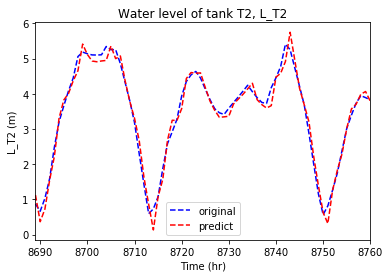

In [32]:
real_vs_predict(test, predictions, 
                title = 'Water level of tank T2, L_T2', 
                ylabel = 'L_T2 (m)')

### Pressure at junction J302, *P_J302*
We can also try a differnt length of testing data, e.g., 5 days.

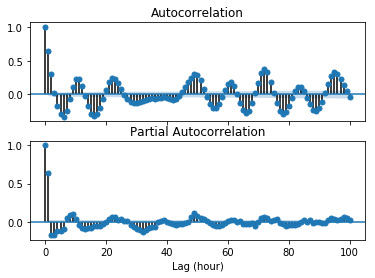

In [76]:
train, test = split_train_test(dftrain1.P_J302, n = 24*5)
acf_plots(train, lag = 100)

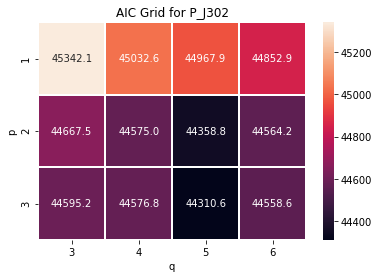

In [77]:
aic_heatmap(train, ps = range(1, 3+1), qs = range(3, 6+1), 
            title = 'AIC Grid for P_J302')

In [78]:
predictions, error = arma_train_predict(train, test, p=2, q=5)

print('ARMA resulting mean square error: %0.3f' % error)

ARMA resulting mean square error: 9.676


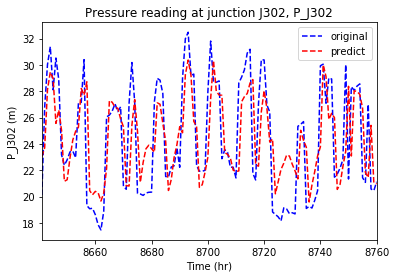

In [79]:
real_vs_predict(test, predictions, 
                title = 'Pressure reading at junction J302, P_J302', 
                ylabel = 'P_J302 (m)')

### Flowrate at pump PU2, *F_PU2*

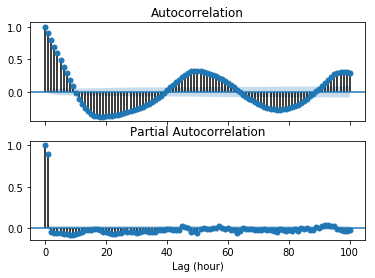

In [80]:
train, test = split_train_test(dftrain1.F_PU2, n = 24*3)
acf_plots(train, lag = 100)

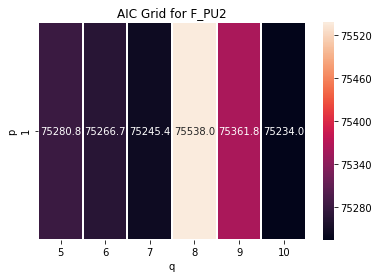

In [65]:
aic_heatmap(train, ps = range(1, 1+1), qs = range(5, 10+1), 
            title = 'AIC Grid for F_PU2')

In [66]:
predictions, error = arma_train_predict(train, test, p=1, q=7)

print('ARMA resulting mean square error: %0.3f' % error)

ARMA resulting mean square error: 242.696


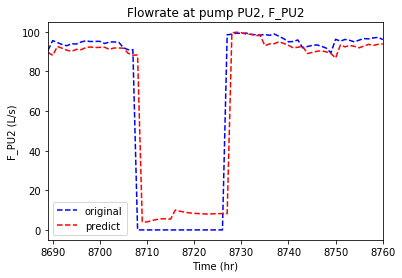

In [67]:
real_vs_predict(test, predictions, 
                title = 'Flowrate at pump PU2, F_PU2', 
                ylabel = 'F_PU2 (L/s)')

## Detecting anomalies
We now apply ARMA model for anomalies dection by the following steps:
- Train the model using the two training datasets;
- Test the model using the test dataset.


In [84]:
# Load dataset
dftrain1 = pd.read_csv('./data/BATADAL_dataset03.csv')
dftrain2 = pd.read_csv('./data/BATADAL_dataset04.csv')
dftest = pd.read_csv('./data/BATADAL_test_dataset.csv')

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))
dftrain2.DATETIME = dftrain2.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))
dftest.DATETIME = dftest.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))